# LT3637 Regulator Design Calculations

This notebook is prepared as an example design of an Analog Devices LT3637 step-down regulator for a fictitious set of design requirements.

## Introduction

Information about the part can be found at this link https://www.analog.com/media/en/technical-documentation/data-sheets/3637fa.pdf

The intent of this example is to demonstrate the features and advantages of the notebook format for design analysis and is not necessarily the single most rigorous design you will find. Please exercise caution if using this for actual design.

<div class="alert alert-block alert-info"><b>Formatting Tip:</b> We can use HTML anchor tags to label our document sections and then construct a Table of Contents that links to the section heading.</div>


<a id="TOC"> </a>
## Table of Contents:
1. [Design Requirements](#req)
1. [Peak Current Calculation](#Ipeak)
1. [Inductor Selection](#inductor)
1. [Input Capacitor Selection](#cin)
1. [Output Capacitor Selection](#cout)
1. [Output Voltage Programming](#Vprog)
1. [Enable, OVLO and UVLO](#run)
1. [Catch Diode](#catchD)
1. [Summary & Conclusions](#conclusion)

<a id="req"> </a>
## Design Requirements

We first define some requirements for our switching converter to use for this example. The beauty of the notebook format is that changes in assumptions and requirements later can propagate through the analysis if we wish to adjust a requirement. 

<div class="alert alert-block alert-info"><b>Formatting Tip:</b> We can use LaTex formatting for equations in the Markdown cells. If your LaTex formatting is a bit rusty, you can use a GUI equation generator like https://www.tutorialspoint.com/latex_equation_editor.htm to create the equations and past them into the markdown.</div>


$
\begin{align}
V_{in-min} = 40 V
\end{align}
$

$
\begin{align}
V_{in-max} = 55 V
\end{align}
$

$
\begin{align}
V_{out} = 20 V
\end{align}
$

$
\begin{align}
I_{out-max} = 500 mA
\end{align}
$



We begin by setting up our variables in a code cell immediately below.


In [ ]:
V_in_min = 40

V_in_max = 55

V_out = 20

I_out = .5

<a id="Ipeak"> </a>
## Peak Current Calculation

The datasheet recommends first setting the peak inductor current. Our maximum output current is 500 mA so we use the equation and graph in the data sheet. 

<div class="alert alert-block alert-info"><b>Formatting Tip:</b> We can easily paste graphs, screen-snips, etc. into this markdown text for reference. Just use ctrl+V while editing the markdown cell</div> 

In this case, we can calculate the Iset resistor value and compare the value to that on the graph provided as a sanity check.

\begin{align}
I_{peak} = 2 \cdot I_{out}
\end{align}

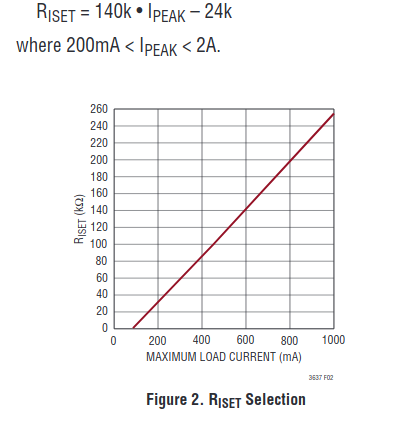

Keep in mind that you can simply state the name of variable at the end of your code cell to display its value or you can use the **print** function to display multiple values or annotations along with the value itself. If you wish to print multiple things on a line, separate them by commas. If you want to print out text, enclose it in either single or double quotes. Variable names do not get quotes.


In [ ]:
I_peak = 2 * I_out

I_peak

In [ ]:
print("The peak inductor current is:", I_peak, "Amps")

In [ ]:
R_iset = 140 * I_peak - 24

print("The peak current setting resistor is:", R_iset, "k Ohms")

<a id="inductor"> </a>
## Inductor Selection


We next need to select a value for the main switching inductor. From the datasheet:

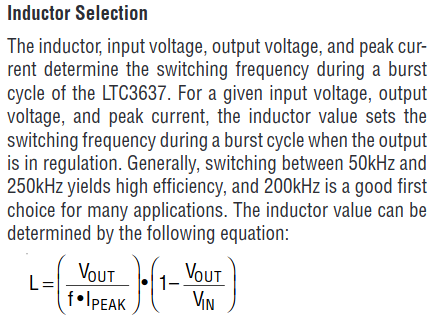

In this case, we would want to use nominal input voltage rather than minimum or maximum so we'll calculate that here so that it updates automatically if we ever change our requirements.

We also need to select (i.e assume) a switching frequency and set that as a variable. Notice that we can use scientific notation in our number with a lowercase e. That may be inconvenient when printing. 

You can perform math even inside the "print" statement to scale a value to more conventional units. If we were to just print out F_switch, it would print out 200000. Let's divide what we print out by 1000 so it's a bit easier on the eyes and then label it in kHz.


In [ ]:
F_switch = 200e3

V_in_nom = (V_in_min + V_in_max) / 2

print("Assumed switching frequency:", F_switch/1000, "kHz")
print("Nominal input voltage:",V_in_nom, "V")

In [ ]:
L = (V_out / (F_switch + I_peak)) * (1 - (V_out / V_in_nom))

print("Calculated Exact Inductor:", L, "H") 
print("Calculated Exact Inductor:", L / 1e-6, "uH") 

Mathing our way through the equation says we need ~58 uH inductor. Thats not a value you can buy. We ***could*** now manually set it to the closest standard value and use that in the rest of our calculation


In [ ]:
L = 56e-6

print("Standard Inductor:", L, "H") 
print("Standard Inductor:", L / 1e-6, "uH") 

<div class="alert alert-block alert-danger"><b>Danger:</b> This type of override of the calculated values breaks the propagation of new parameters through the notebook. Caution should be exercised when doing this. </div>

<div class="alert alert-block alert-info"><b>Formatting Tip:</b> You can use these formatting blocks to express warnings of various types to yourself or other users at places that are likely to cause consternation. See the very well-written formatting guide at https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd for some additional examples </div>

A more sophisticated approach less prone to this danger is to create a function that uses a list of standard values and selects the closest one automatically so we don't fall into this trap of manually *hard coded* values if we change an input parameter and forget that we adjusted something to align with a standard/available value. 

The mechanics of this function is a little outside the scope of this demo. Just observe that it works. If how this works is really eating at you, a short explanation is this:


1. We take our desired component value as the input to our function.

1. We take the base 10 log of the number and round that down (floor division) to the nearest whole number to give us the order of the exponent when expressed as scientific notation.

1. We divide the number by 10 to the exponent to get a value that is between 1 and 10 (the same as the base number of the E series of standard values, in this case E24.

1. We take the array of E-series numbers and subtract our desired number from each and the take the absolute value of that.

1. The minimum difference is the closest number, we find the index of the minimum value (its position in the list) and then take the standard value located at that same position in the original list.

1. We multiply it by 10 to the exponent to get back our standard value.

In [ ]:
import numpy as np
import math

def standard_value(desired_value): 
    component_order = math.floor(math.log10(desired_value))
    E24 = [1.0,1.1,1.2,1.3,1.5,1.6,1.8,2.0,2.2,2.4,2.7,3.0,3.3,3.6,3.9,4.3,4.7,5.1,5.6,6.2,6.8,7.5,8.2,9.1,10] 
    lst = np.asarray(E24)
    idx = (np.abs(lst - desired_value/(10**component_order))).argmin() 
    return lst[idx]*10**component_order 


In [ ]:
L = 5.7894447369868417e-05

L_actual = standard_value(L)

print("The automatically-chosen inductor value is:",L_actual / 1e-6, "nH")

## Minimum Switching Time

Per the datasheet:

> An  additional  constraint  on  the  inductor  value  is  the  LTC3637’s 150ns minimum on-time of the high side switch. Therefore,  in  order  to  keep  the  current  in  the  inductor  well-controlled, the inductor value must be chosen so that LTC3637 is larger than a minimum value which can be computed as follows, where VIN(MAX) is the maximum input supply voltage when switching is enabled, tON(MIN) is 150ns, IPEAK is the peak current, and the factor of 1.2 accounts for typical inductor tolerance and variation over temperature. 

<div class="alert alert-block alert-info"><b>Formatting Tip:</b>We can insert quote blocks to show that text is a copy-paste from another document </div>

$
\begin{align}
L > \frac{V_{in(max)} \cdot t_{on(min)}}{I_{peak}} \cdot 1.2
\end{align}
$

We begin with the specified minimum on time from the datasheet. We then compute L_min.

In [ ]:
t_on_min = 150e-9

L_min = (V_in_max * t_on_min) / I_peak * 1.2

print("Specified Minimum On-Time:", t_on_min, "s")
print("Calculated Minimum Inductor Value:", L_min / 1e-6, "uH")

**A word on "print" statement formatting...**

You'll notice that we get a ton of useless digits on minimum inductor value. There are a couple of ways of making that more pleasant to look at. You can round the number (up, down, closest) or you can simply truncate the number of digits displayed. In the cell below, a few examples of how to format what you output.

Both examples use the number formatting with the % operator. 

Its important to note at this point that we're not changing the value stored in the variable, just adjusting the way its displayed. All precision is retained for future calculations which use the variable.

In [ ]:
print("Calculated Minimum Inductor Value:", "%.2f" % (L_min / 1e-6), "uH")
print("Calculated Minimum Inductor Value:", "%.4f" % (L_min / 1e-6), "uH")

In the following cell, we introduce an **IF** statement such that if the chosen inductor value (L_actual) is greater than the minimum, that value is used. If it is less than the minimum, the minimum standard value is used.

In [ ]:
if (L_actual <= L_min):
    L_actual = standard_value(L_min)
    
print("Chosen inductor, respecting minimum:", "%.2f" % (L_actual / 1e-6), "uH")

<a id="cin"></a>
## Input Capacitor Selection

From the datasheet:

> The input capacitor, CIN, is needed to filter the trapezoidal current  at  the  source  of  the  top  high  side  MOSFET.  CIN should be sized to provide the energy required to charge the  inductor  without  causing  a  large  decrease  in  input  voltage  (∆VIN).  The  relationship  between  CIN  and  ∆VIN is given by:

$
\begin{align}
C_{in} = \frac{L \cdot I_{peak}^2}{2 \cdot V_{in} \cdot \triangle V_{in}}
\end{align}
$


> It  is  recommended  to  use  a  larger  value  for  CIN  than  calculated  by  the  above  equation  since  capacitance  de-creases  with  applied  voltage.  In  general,  a  4.7μF  X7R  ceramic capacitor is a good choice for CIN in most LTC3637 applications.

In [ ]:
Delta_V_in = 1

C_in = (L_actual * I_peak**2) / (2 * V_in_min * Delta_V_in)

print("Minimum Cin for assumed delta-Vin of", "%.2f" % Delta_V_in, "Volts:", "%.2f" % (C_in / 1e-6), "uF")

In [ ]:
C_in_actual = standard_value(C_in)

print("Minimum Cin Standard Value:", "%.2f" % (C_in_actual/ 1e-6), "uF")

We have calculated the minimum value of input capacitence per the equation, but comparing it to the datasheet's recommendation, we may be less than the value they recommend as a floor. We again use the **If** statement to choose what to do based on whether the minimum we calculated is greater or less than the 4.7uF recommended. We also introduce the **Else** block that is run if our **If** condition is not met.

In [ ]:
C_in_min = 4.7e-6
print("Manufacturer's reccomendent Minimum Cin is:", "%.2f" % (C_in_min/ 1e-6), "uF")

if (C_in_actual <= C_in_min):
    C_in_actual = standard_value(C_in_min)
    print("Calculated Cin is less than reccomended minimum, using", "%.2f" % (C_in_min/ 1e-6), "uF")
else:
    print("Calculated Cin is greater than reccomended minimum, using", "%.2f" % (C_in_actual/ 1e-6), "uF")
    

> To minimize large ripple voltage, a low ESR input capacitor sized for the maximum RMS current should be used. RMS current is given by:

$
\begin{align}
I_{RMS} = I_{out} \cdot \frac{V_{out}}{V_{in}} \cdot \sqrt{\frac{V_{in}}{V_{out}} - 1}
\end{align}
$

In [ ]:
I_rms = (I_out * V_out / V_in_nom) * ((V_in_nom / V_out) -1)**(-2)

print("RMS Inductor Current for Vin =",V_in_nom,"Volts:", "%.2f" % (I_rms/ 1e-3), "mA")

Up until this point, you may have looked at this thought there was no advantage to code over pencil-and-paper or a spreadsheet. One of the greatest powers of this method is being able to operate on sets of data rather than just a single point. In the next cell, we ask the question: 

> "We assumed Vin was the nominal case for calculating our ripple current. What happens to ripple current across the whole range of our input voltages?"

First, we return to the NumPy matrix math library that we used earlier for our standard E-series value function to create an array of possible Vin values. We use the **linspace** command (this will be familiar to you if you're a MATLAB user). The **linspace** command takes the minimum value, the maximum value, and the number of points, respectively. We create an array ranging from Vin-min to Vin-max with 101 points, extents included. We print out the array of voltages to show how this works. Notice that an array of this type is enclosed with square brackets and with each element separated by a space.



In [ ]:
V_in_range = np.linspace(V_in_min, V_in_max, 101)

print(V_in_range)

The beauty of the the Python coding is that you can use the array of values as you would a single point number. We use the same equation as before but substitute our array for V_in_nom and get an array of outputs corresponding to each input.

In [ ]:
I_rms_range = (I_out * V_out / V_in_range) * ((V_in_range / V_out) -1)**(-2)

print(I_rms_range)

Now, lets inspect the data. We import the ubiquitous plotting library MATPLOTLIB. The most basic usage of plotting to plot command of the plt library. You then pass arguments to the function of the X data and the Y data. We can also add some bells and whistles like axis labels.


In [ ]:
import matplotlib.pyplot as plt

plt.plot(V_in_range, I_rms_range * 1000)
plt.ylabel('RMS Capacitor Current [mA]')
plt.xlabel('Input Voltage [V]')


<a id="cout"></a>
## Output Capacitor Selection

We now select the output capacitor value using the equations in the datasheet.

> The  output  capacitor,  COUT,  filters  the  inductor’s  ripple  current and stores energy to satisfy the load current when the LTC3637 is in sleep. The output ripple has a lower limit of VOUT/160 due to the 5mV typical hysteresis of the feed-back comparator. The time delay of the comparator adds an additional ripple voltage that is a function of the load current. During this delay time, the LTC3637 continues to sitch and supply current to the output. The output ripple can be approximated by:

$
\begin{align}
\Delta V_{out} \thickapprox  \left( {\frac{I_{peak}}{2} - I_{Load} } \right) \cdot \frac{4 \cdot 10^{-6}}{C_{out}} + \frac{V_{out}}{160}
\end{align}
$

We again use our plotting trick to play a game of *what if* by defining an array of output currents and substituting it into the equation and plotting the result.





In [ ]:
I_out_array = np.linspace(0,I_out,101)

print(I_out_array)


In [ ]:
C_out = 10e-6

Delta_V_Out = (I_peak/2 - I_out_array) * (4e-6 / C_out) + V_out/160

plt.plot(I_out_array*1000, Delta_V_Out, label="10uF")
plt.ylabel('Delta Vout Ripple [V]')
plt.xlabel('Output Current [mA]')
plt.legend()

Now, lets add another tool to our toolbox and use it to visualize the effect of capacitor value on the ripple current. To do this, we'll employ a **for** loop to make multiple traces on our plot, one each for the different values of capacitor in a list of C_out values.

In [ ]:
C_out_list = [4.7e-6, 6.8e-6, 10e-6, 20e-6]

for capacitor in C_out_list:
    Delta_V_Out = (I_peak/2 - I_out_array) * (4e-6 / capacitor) + V_out/160
    plt.plot(I_out_array*1000, Delta_V_Out, label="%.2f"%(capacitor/1e-6)+" uF")
    
plt.ylabel('Delta Vout Ripple [V]')
plt.xlabel('Output Current [mA]')
plt.legend()

The behavior seen in the plot corresponds to the description in the datasheet:

> The output ripple is a maximum at no load and approaches lower  limit  of  VOUT/160  at  full  load.  

>Choose  the  output  capacitor  COUT  to  limit  the  output  voltage  ripple  ∆VOUT using the following equation:

We must assume the amount of V_out ripple we're willing to tolerate and then calculate minimum capacitor accordingly.

$
\begin{align}
C_{out} \geq  \frac{I_{peak} \cdot 2 \cdot 10^{-6}}{\Delta V_{out} - \frac{V_{out}}{160}}
\end{align}
$

>The value of the output capacitor must be large enough to accept the energy stored in the inductor without a large change in output voltage during a single switching cycle.Setting this voltage step equal to 1% of the output voltage, the output capacitor must be:

$
\begin{align}
C_{out} > 50 \cdot L \cdot \left( \frac{I_{peak}}{V_{out}}\right)^2
\end{align}
$




In [ ]:
Delta_V_out = 0.2

C_out_min = (I_peak * 2e-6)/(Delta_V_out - (V_out / 160))

print("Calculated Minimum Cout for Vout ripple of", "%.2f" % (Delta_V_out*1000), "mV: ""%.2f" % (C_out_min/1e-6), "uF")
print("The closest standard capacitor value:", "%.2f" % (standard_value(C_out_min)/1e-6),"uF")

In [ ]:
C_out_min_L = 50 * L_actual * (I_peak / V_out)**2

print("Calculated Minimum Cout for Inductor ripple: ""%.2f" % (C_out_min_L/1e-6), "uF")
print("The closest standard capacitor value:", "%.2f" % (standard_value(C_out_min_L)/1e-6),"uF")

<a id="Vprog"></a>
## Output Voltage Programming

The last thing to calculate is the output voltage setting feedback resistors.

> The LTC3637 has three fixed output voltage modes that can  be  selected  with  the  VPRG1  and  VPRG2  pins  and  an  adjustable mode. The fixed output modes use an internal feedback divider which enables higher efficiency, higher noise  immunity,  and  lower  output  voltage  ripple  for  5V,  3.3V and 1.8V applications. 
For the adjustable output mode (VPRG1 = 0V, VPRG2 = 0V), the output voltage is set by an external resistive divider according to the following equation: 

$
\begin{align}
V_{out} = 0.8 V \cdot \left( 1 + \frac{R_{1}}{R_{2}}\right)
\end{align}
$

> The resistive divider allows the VFB pin to sense a fraction of  the  output  voltage  as  shown  in  Figure  7.  The  output  voltage can range from 0.8V to VIN. Be careful to keep the divider resistors very close to the VFB pin to minimize the trace length and noise pick-up on the sensitive VFB signal.

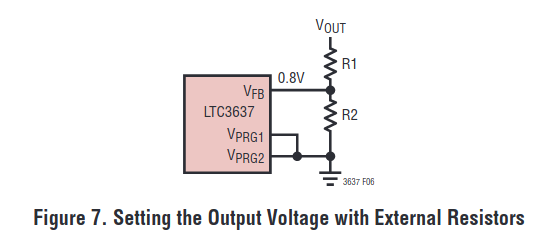

In [ ]:
R_1 = 10e3

R_2 = R_1 / ((V_out / .8) - 1)

print("Closest standard value R1:", "%.2f" % (standard_value(R_1)),"ohms")
print("Closest standard value R2:", "%.2f" % (standard_value(R_2)),"ohms")

V_out_actual = 0.8 * (1 + (standard_value(R_1)/standard_value(R_2)))

print("Actual Output Voltage with Standard Values", "%.2f" % V_out_actual,"V")

V_error = abs(V_out_actual-V_out) /  V_out

print("Voltage Error:", "%.2f" % (V_error*100),"%")

Lets say that we want to try a range of values and look at it on a plot to try to find a combination that gives the minimum error graphically.

This is a more advanced bit of code that I'm not going to explain in detail. I've added comment for the curious. I can explain if need be.

In [ ]:
# Our list of standard values
E24 = [1.0,1.1,1.2,1.3,1.5,1.6,1.8,2.0,2.2,2.4,2.7,3.0,3.3,3.6,3.9,4.3,4.7,5.1,5.6,6.2,6.8,7.5,8.2,9.1,10] 

# Use valeues in the range of 10k to 100k
R_1_Array = np.asarray(E24) * 10e3

# Calculate the corrisponding R2 for reach possible R1. All operations on the array are scalar
R_2_Array = R_1_Array / ((V_out / .8) - 1)

# We can't pass the whole array to our closest-standard-value-function, so we have to do them 1 at a time
# Create empty array to hold our result
R_2_Array_std = []

# Loop over all the R1 values, doing the calculation on each
for R in R_2_Array:
    # Calculate the standard value for the Rth element of the array, append it to the new array
    R_2_Array_std.append(standard_value(R))
    
# Calculate the acutal output volatge. DANGER: We're dividing matricies. We need to use np.divide to do it element-wise
V_out_actual_Array = 0.8 * (1 + (np.divide(R_1_Array,R_2_Array_std)))
# Find the error terms
V_error_Array = abs(V_out_actual_Array-V_out) /  V_out

# Plot error vs input R1 value.
plt.plot(R_1_Array/1000, V_error_Array*100)
plt.xlabel("R1 Value [kOhms]")
plt.ylabel("Voltage Error [%]")

# Use the NumPy argmn function to return the array index of the minimum value of error in the error array
# Use that index to retrieve the corrisponding R1 value
print(R_1_Array[np.argmin(V_error_Array)]/1000, "k ohms")

In [ ]:
R_1 = R_1_Array[np.argmin(V_error_Array)]

R_2 = R_1 / ((V_out / .8) - 1)

print("Closest standard value R1:", "%.2f" % (standard_value(R_1)),"ohms")
print("Closest standard value R2:", "%.2f" % (standard_value(R_2)),"ohms")

V_out_actual = 0.8 * (1 + (standard_value(R_1)/standard_value(R_2)))

print("Actual Output Voltage with Standard Values", "%.2f" % V_out_actual,"V")

V_error = abs(V_out_actual-V_out) /  V_out

print("Voltage Error:", "%.2f" % (V_error*100),"%")

<a id="run"></a>
## Enable, OVLO and UVLO

We can set undervoltage lock out (UVLO) and overvoltage lock out (OVLO) with a resistor network. From the datasheet:

>The RUN and OVLO pins can alternatively be configured as precise undervoltage (UVLO) and overvoltage (OVLO) lockouts on the VIN supply with a resistive divider from VIN to ground. A simple resistive divider can be used as shown in Figure 10 to meet specific VIN voltage requirements. The current that flows through the R3-R4-R5 divider will directly add to the shutdown, sleep, and active current of the LTC3637, and care should be taken to minimize the impact of this current on the overall efficiency of the application circuit. Resistor values in the megaohm range may be required to keep the impact on quiescent shutdown and sleep currents low. To pick resistor values, the sum total of R3 + R4 + R5 (RTOTAL) should be chosen first based on the allowable DC current that can be drawn from VIN. The individual values of R3, R4 and R5 can then be calculated from the following equations:


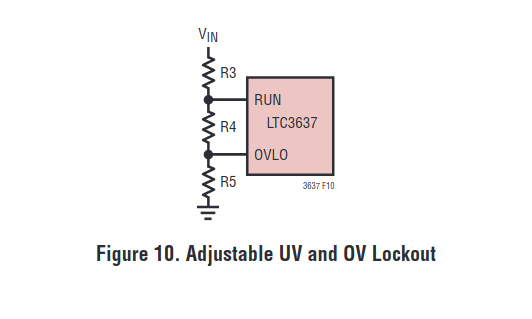


$
\begin{align}
R_{5} = R_{total} \cdot \left( \frac{1.21 V}{V_{in-rising \cdot OVLO_{threshold}}}\right)
\end{align}
$


$
\begin{align}
R_{4} = R_{total} \cdot \left( \frac{1.21 V}{V_{in-rising \cdot UVLO_{threshold}}}\right)- R_{5} 
\end{align}
$


$
\begin{align}
R_{5} = R_{total} - R_{5}  - R_{4} 
\end{align}
$

In [ ]:
R_total = 100e3
OVLO = 56
UVLO = 38

R_5 = R_total * (1.21 / OVLO)
R_5_actual = standard_value(R_5)

R_4 = R_total * (1.21 / UVLO) - R_5_actual
R_4_actual = standard_value(R_4)

R_3 = R_total - R_5_actual - R_4_actual 
R_3_actual = standard_value(R_3)

print("R3:", "%.2f" % (R_3_actual/1000), "k Ohms")
print("R4:", "%.2f" % (R_4_actual/1000), "k Ohms")
print("R5:", "%.2f" % (R_5_actual/1000), "k Ohms")



In [ ]:
V_OVLO_pin = V_in_max * R_5_actual / (R_3_actual + R_4_actual + R_5_actual)

V_in_on = 1.21 / (R_4_actual + R_5_actual) * (R_4_actual + R_5_actual + R_3_actual)

print("Voltage at OVLO Pin:", "%.2f" % (V_OVLO_pin), "V")
print("Turn On Threshold:", "%.2f" % V_in_on, "V")

<a id="catchD"></a>
## Catch Diode Requirements

$
\begin{align}
I_{D-Avg} = \frac{I_{out} \cdot V_{in}}{(V_{in}-V_{out})}
\end{align}
$


In [ ]:
I_D_avg = (I_out * V_in_min)/(V_in_min - V_out)

print("  Catch Diode Average Current:", "%.2f" % (I_D_avg ), "A")

<a id="conclusion"></a>
## Summary & Conclusions

In [ ]:
print("Input Parameters:")
print("------------------------------------")
print("  Input Voltage Min :","%.2f" % V_in_min, "V")
print("  Input Voltage Max :","%.2f" % V_in_max, "V")
print("  Input Voltage Nom :","%.2f" % V_in_nom, "V")
print("  Output Voltage    :","%.2f" % V_out, "V")
print("  Output Max Current:","%.2f" % I_out, "A")
print('\n')
print("Component Values:")
print("------------------------------------")
print("  L    :", "%.2f" % (L_actual/1e-6), "uH")
print("  Cin  :", "%.2f" % (C_in_actual/1e-6), "uF")
print("  Cout :", "%.2f" % (standard_value(C_out_min)/1e-6), "uF")
print("  R1   :", "%.2f" % (standard_value(R_1)),"ohms")
print("  R2   :", "%.2f" % (standard_value(R_2)),"ohms")
print("  Riset:", "%.2f" % (standard_value(R_iset)), "k Ohms")
print("  R3   :", "%.2f" % (R_3_actual/1000), "k Ohms")
print("  R4   :", "%.2f" % (R_4_actual/1000), "k Ohms")
print("  R5   :", "%.2f" % (R_5_actual/1000), "k Ohms")
print('\n')
print("Calculated Operating Point:")
print("------------------------------------")
print("  RMS Inductor Ripple  :", "%.2f" % (I_rms/ 1e-3), "mA")
print("  Actual Output Voltage:", "%.2f" % V_out_actual,"V")
print("  Output Voltage Error :", "%.2f" % (V_error*100),"%")
print("  Voltage at OVLO Pin  :", "%.2f" % (V_OVLO_pin), "V")
print("  Turn On Threshold    :", "%.2f" % V_in_on, "V")
print("  Catch Diode Current  :", "%.2f" % (I_D_avg ), "A")